<a href="https://colab.research.google.com/github/TaliNatan/DSPS_TNatan/blob/main/HW7/clusteringGenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install umap-learn
!pip install umap-learn[plot]

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import scipy as sp
import sklearn as skl
from scipy import stats
from sklearn import cluster
import umap
import umap.plot
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

from sklearn.manifold import TSNE

import missingno as msno

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1: Read in the data


In [3]:
genes = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/HW7/kidpackgenes.csv", index_col=0)

In [4]:
genes.shape

(4224, 74)

In [5]:
genes.head()

,1,2,3,4,5,6,7,8,10,11,...,76,77,78,79,81,83,84,85,86,87
1,-0.146342,-0.520637,0.175828,-0.323736,0.172691,0.025156,0.024812,0.172268,0.207188,0.026710,...,0.240705,-0.347746,-0.001797,-0.260594,0.105968,0.110885,-0.006975,0.550118,0.118934,0.327248
2,-0.465767,0.155823,0.226344,-0.547542,0.041096,0.137012,0.102497,-0.034277,0.500871,0.005533,...,0.371435,-0.447105,-0.134904,-0.250699,0.164698,-0.035022,0.250384,0.463746,-0.514230,0.200956
3,-0.088964,-0.208241,-0.151039,-0.288229,-0.425568,0.121006,-0.097883,-0.007597,0.329636,-0.222495,...,-0.014990,-0.458297,-0.050852,-0.168500,0.078716,-0.032231,-0.116947,-0.199880,-0.415793,-0.032004
4,-0.327696,-1.714948,0.068710,-0.168257,-0.471577,0.279013,-0.060734,-0.222574,0.658097,0.129876,...,0.153765,-0.140409,-0.119515,-0.289881,0.944493,-0.142710,-1.119866,-0.215536,0.345946,0.056442
5,-0.092327,-0.660456,0.075948,-0.646501,-0.046137,-0.010305,0.368476,-0.043832,-0.321060,0.116657,...,-0.033032,0.394082,0.173515,-0.194819,0.149131,-0.097285,-0.288192,-0.491920,-0.722120,0.055477


# 2: Explore and preprocess the data


## 2a:
missing values? (remember you can use the missingno package and visualize the missing values!). What should you do with them?

<Axes: >

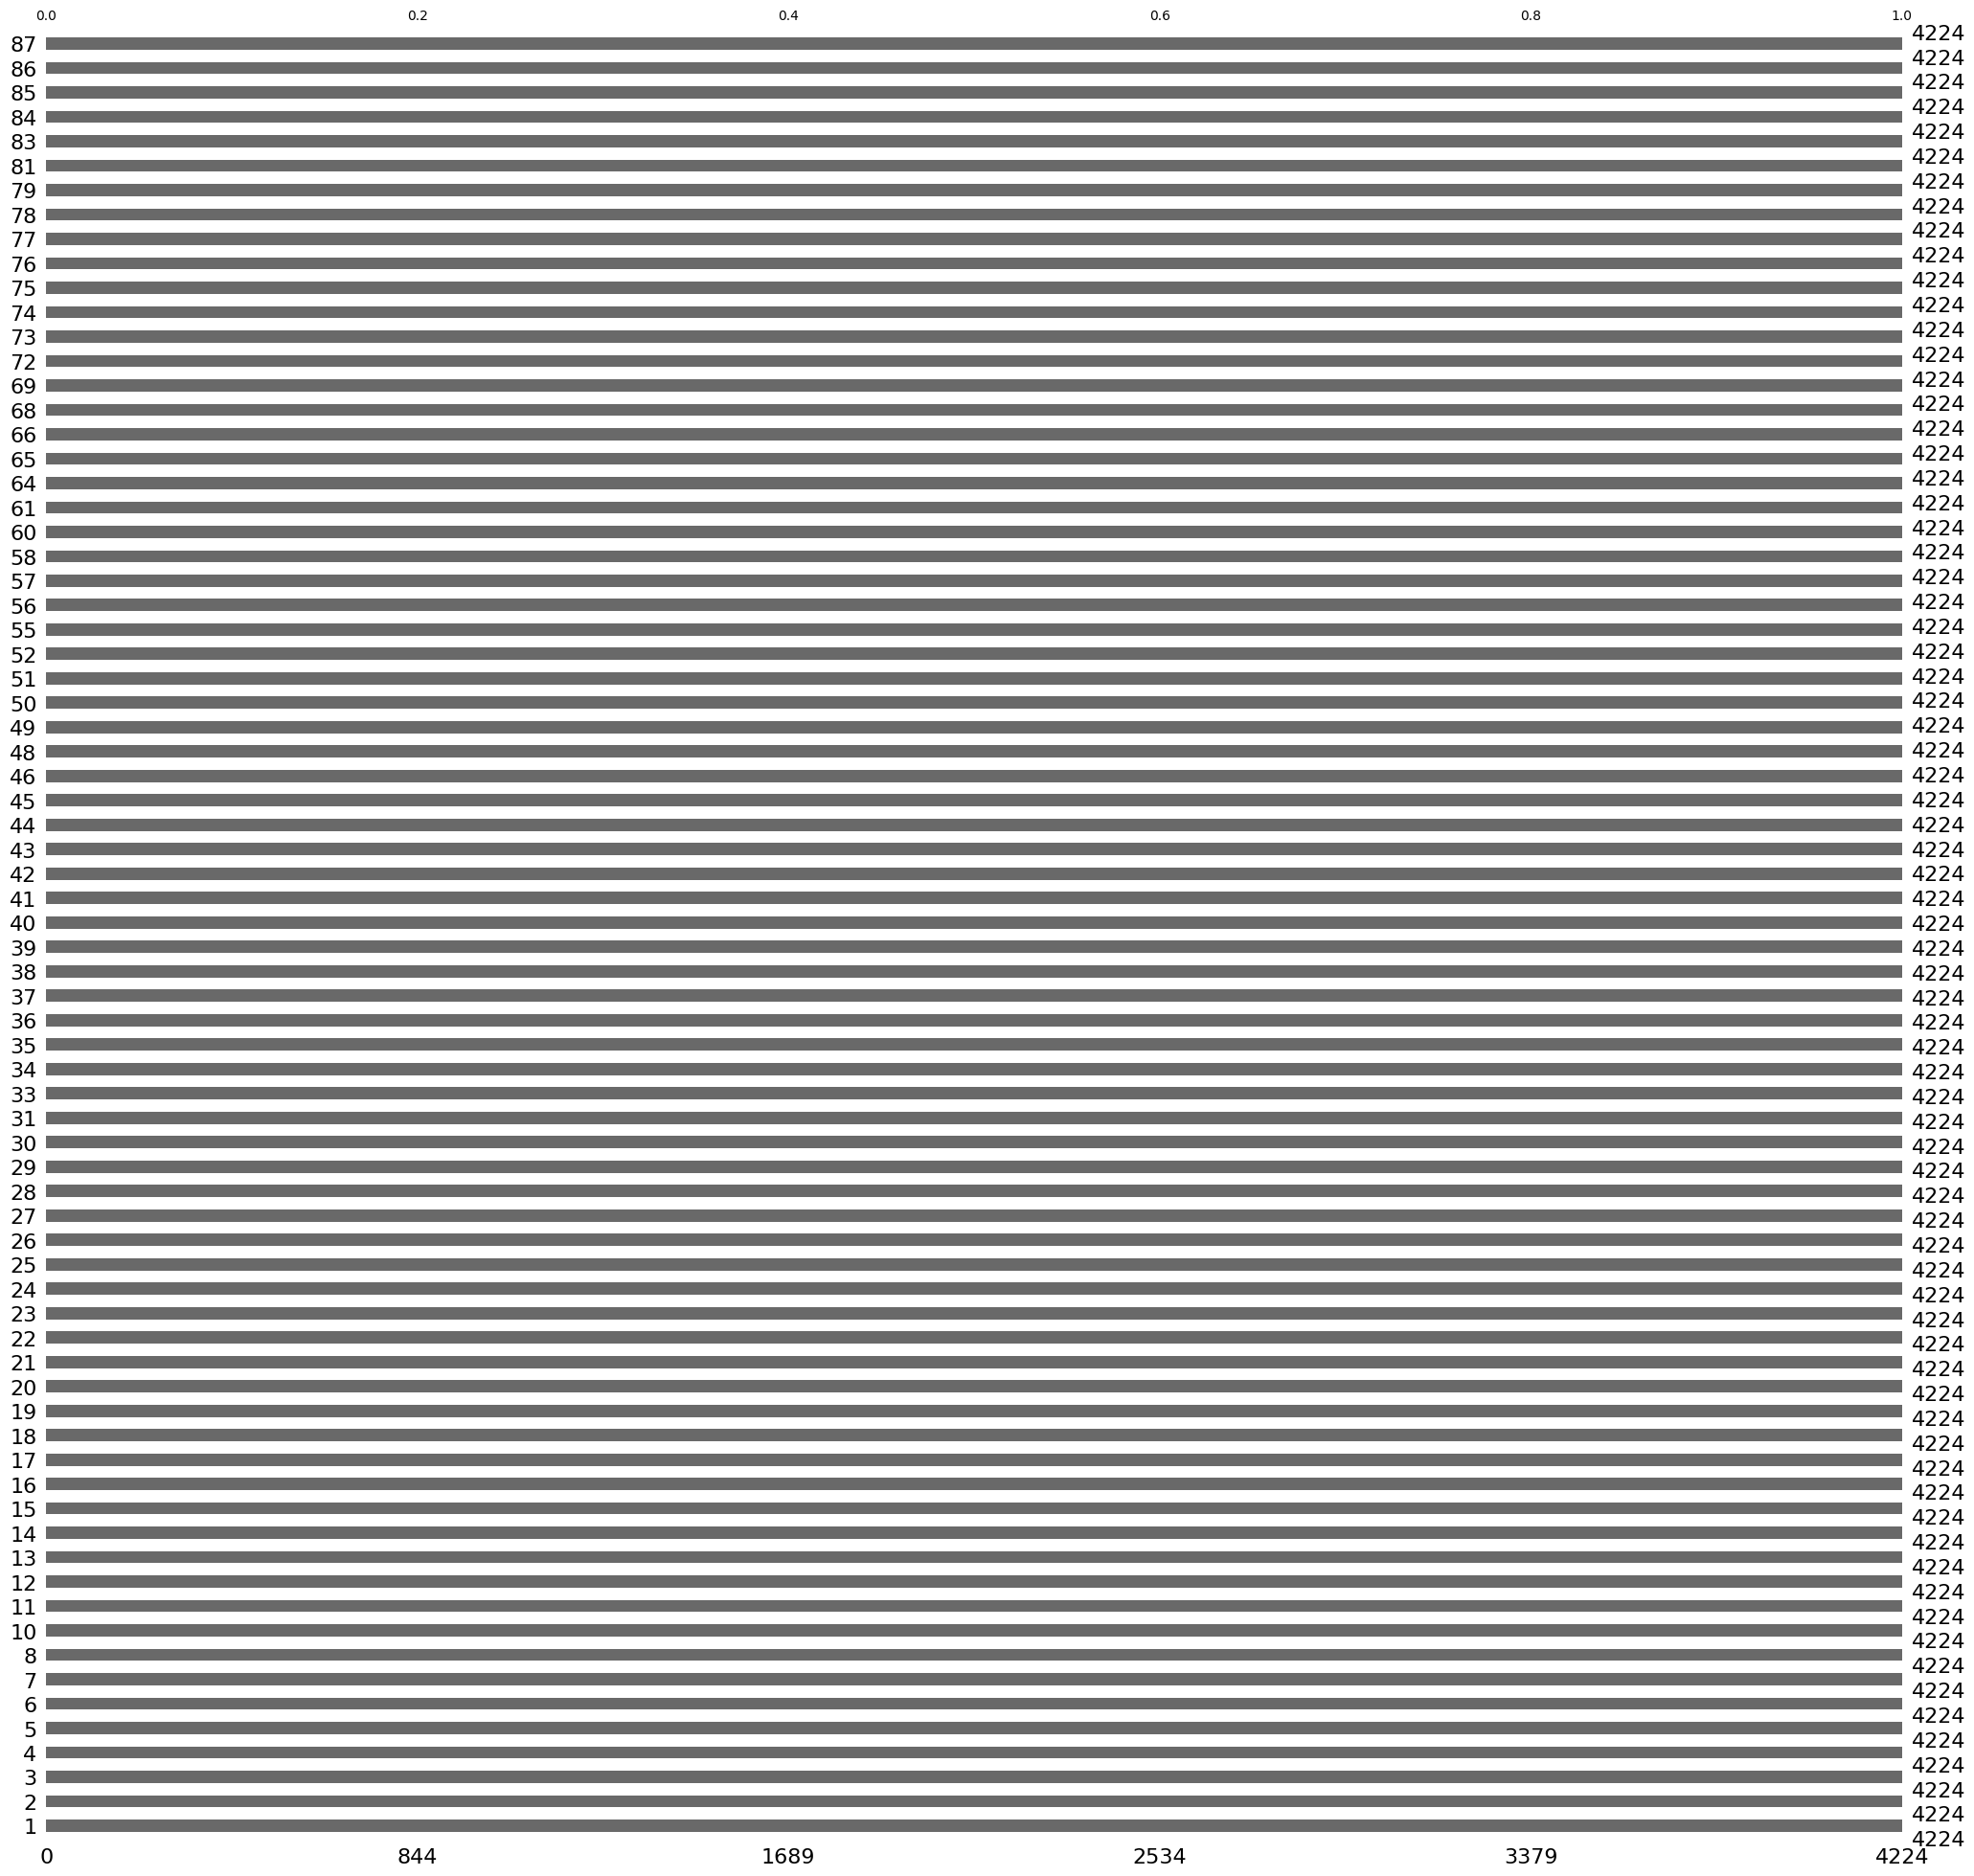

In [6]:
msno.bar(genes)
# no missing values

The above figure is a bar plot showing the the number of values per column. Since all the columns have 4,224 values, we know there are no missing values in our data.

## 2b:
Normalize it. What is appropriate? discuss your choices...
It was appropriate to normalize the data so that columns can be viewed in the same space/with similar representation.

In [7]:
np_genes = genes.to_numpy()

scaledgenes = np.zeros(np_genes.shape)

for i in range(np_genes.shape[1]):
  scaledgenes[:, i] = (np_genes[:, i] - np.mean(np_genes[:, i])) / np_genes[:, i].std()

# 3: Visualize the data


## 3a: Calculate and plot a t-SNE projection of the data on an optimal 2D plane

In [8]:
n_components = 2
tsne = TSNE(n_components, perplexity = 30)
tsne_result = tsne.fit_transform(scaledgenes)

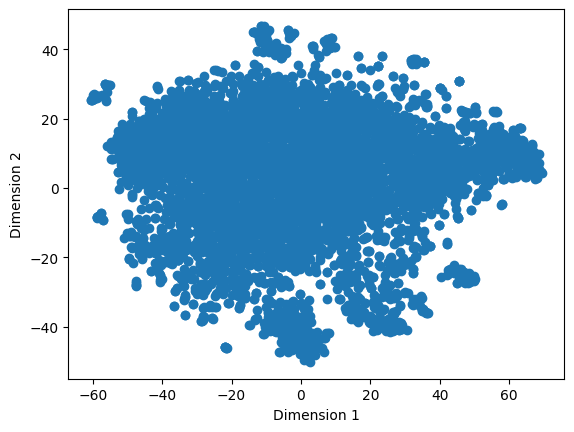

In [9]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is t-SNE projection of the normalized gene data on a 2-D projection with perplexity 30 We can see that there exists some clumping of the data that is comes from underlying structure.

## 3b: Calculate and plot the UMAP 2D projection

In [10]:
fit = umap.UMAP(n_neighbors = 50)
u = fit.fit_transform(scaledgenes)


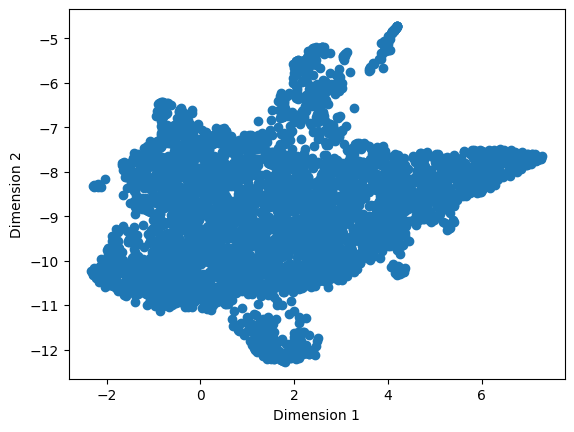

In [11]:
plt.scatter(u[:,0], u[:,1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is UMAP projection of the normalized gene data on a 2-D projection with n_neigbors = 50. We can see that there exists some clumping of the data that is comes from underlying structure.

# 4: K-MEANS Clustering

## 4a: Find the best number of culsters for this dataset

Create a function that measures the intracluster variance

The intracluster variance is the sum of the variance of each cluster
$V =\sum_J \sum_i{(X_{i\in j} - \bar{X_j})^2}$ for $i$ points in $j$ clusters

In [12]:
# def calICVar(X, n_clusters):
#     """calculates the intracluster variance of the k-MEANS algorithm
#     X: the input data (ndarray)
#     n_clusters: # of clusters data is sorted into
#     """
#     clf_km = cluster.KMeans(n_clusters = n_clusters, n_init='auto')
#     labels = clf_km.fit_predict(X)
#     icvar = clf_km.inertia_

#     return icvar


In [13]:
# ### SHAR'S ORIGINAL FUNCTION

# def calICVar(X, labels, centroids):
#     """calculates the intracluster variance of the k-MEANS algorithm
#     X: the input data (ndarray)
#     labels: the labels indicating the cluster of each datapoint: same number of data as X
#     centroids: list of centroids
#     """
#     #okay so we need the mean of each cluster
#     #number of clusters is the number of distinct elements in labels
#     #somehow we need to account for all 74 features i think
#     icvar = 0
#     for i, row in enumerate(X):
#       x_lab = labels[i]
#       diff = (np.linalg.norm(row - centroids[x_lab]))**2
#       icvar+=diff


#     return icvar

In [14]:
def calICVar(X, n_clusters):
    """calculates the intracluster variance of the k-MEANS algorithm
    X: the input data (ndarray)
    n_clusters: # of clusters data is sorted into

    icvar: intracluster variance

    """
    clf_km = cluster.KMeans(n_clusters = n_clusters, n_init='auto')
    labels, centroids = clf_km.fit_predict(X), clf_km.cluster_centers_

    icvar = 0
    for i, row in enumerate(X):
      x_lab = labels[i]
      diff = (np.linalg.norm(row - centroids[x_lab]))**2
      icvar+=diff


    return icvar

Cluster the data with K-Means using 1 to 10 clusters. Calculate the intracluster variance and look for an "elbow" in the value of the intracluster variance as a function of number of clusters. What is the optimal number of clusters?

In [15]:
n_clusters = np.arange(1,11,1)
vars = np.zeros(n_clusters.shape)
for i in range(len(n_clusters)):
  vars[i] = calICVar(scaledgenes, n_clusters[i])

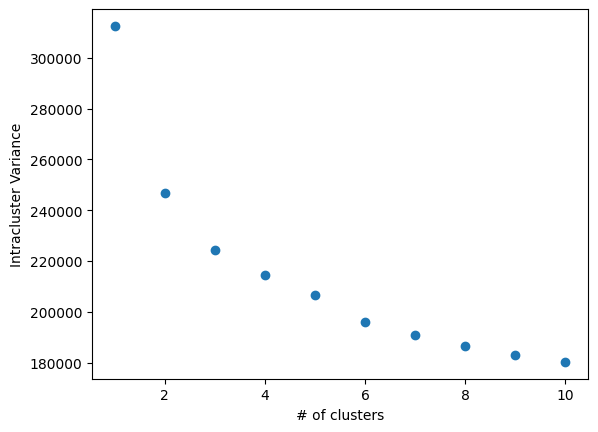

In [16]:
plt.scatter(n_clusters,vars)
plt.xlabel('# of clusters')
plt.ylabel('Intracluster Variance')
plt.show()

Based on the above plot, the "elbow" would be at 2 clusters because that is where the biggest drop is but overall, the intercluster variance is going down (it appears) exponentially. The "best" number of clusters for this data is 2 based on this plot.

## 4b: Cluster the data with k-Means into the number of clusters as determined from the elbow

In [17]:
geneclustersKM = cluster.KMeans(2, n_init='auto')
labels, centroids = geneclustersKM.fit_predict(scaledgenes), geneclustersKM.cluster_centers_


## 4c: Plot the t-SNY and UMAP projections of the data using the cluster number as color

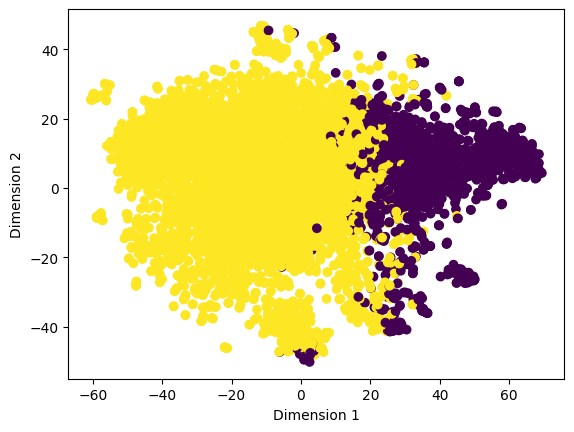

In [18]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is t-SNE projection of the normalized gene data on a 2-D projection and 2 color-coded clumps found using k-means. We can see that the clusters are not very distinct over the projection and that spacially, the clumps don't really make sense. The division is mostly just left side of mass versus right side.

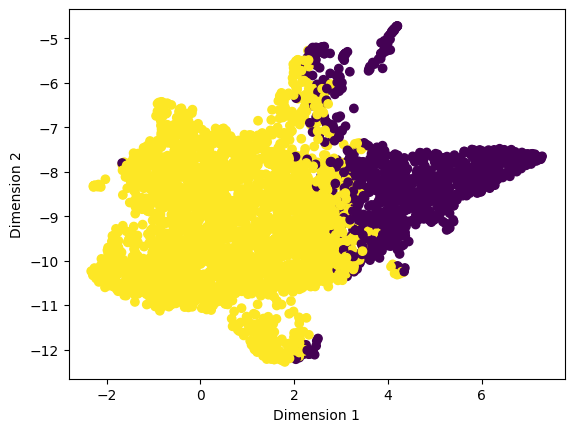

In [19]:
plt.scatter(u[:, 0], u[:, 1], c = labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is UMAP projection of the normalized gene data on a 2-D projection with 2 color-coded clumps found using k-means. We can see that the clusters are not very distinct over the projection and that spacially, the clumps don't make sense. We end up with a candy-corn like division of the mass with no consideration for the upper two blobs.

# Use dDSCAN or hierarchical clustering (461 pick either DBSCAN or hierarchical) and redo the clustering. Can you find the same number of clusters?

# 5: DBSCAN Clustering


## 5a: Measure the distribution of Euclidean distances

It is important to choose the hyperparamters of DBSCAN wisely. Initialize the _eps_ parameter of DBSCAN based on the mean Euclidean distance. To that end, calculate and plot the Euclidean distance matrix of each point pairs if you have not yet

In [20]:
dists = sp.spatial.distance.pdist(scaledgenes, metric='euclidean')
clf_dbs = cluster.DBSCAN(eps = dists.mean(), min_samples = 3, metric = 'euclidean')
labels = clf_dbs.fit_predict(scaledgenes)

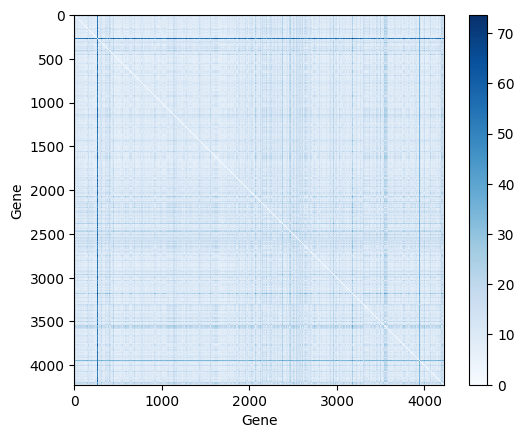

In [21]:
plt.imshow(sp.spatial.distance.squareform(dists), cmap="Blues", interpolation = 'None')
plt.xlabel("Gene")
plt.ylabel("Gene")
plt.colorbar()
plt.show()


The above heat map shows the euclidean distance between normalized points. It makes sense that on the diagonal, the values are 0 since there is no "distance" between a value and itslef. This plaid-like pattern shows that there is some distance relationship between other genes; dark vertical/horizontal lines mean strong anticorrelation between genes.

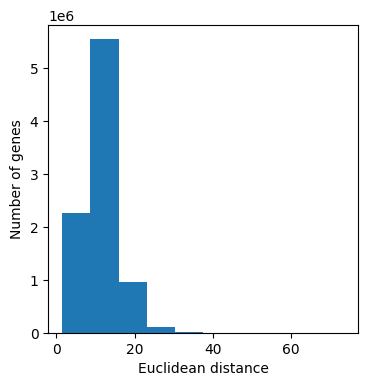

In [22]:
plt.figure(figsize=(4,4))
plt.hist(dists)
plt.xlabel("Euclidean distance")
plt.ylabel("Number of genes")
plt.show()

The above histogram shows that most of the genese are within 20 euclidean distance units of one another - the data is packed quite close and there are not massively disparate groups, atleast as seen with this view.

## 5b: Rub DBSCAN

Initialize the dbscan _eps_ hyperparameter value appropriately and fit a dbscan model to the data plot the 2D TSNE projection colorcoded as before. How many clusters do you have, how many outliers? is that a significant number?

In [23]:
geneclustersDBS = cluster.DBSCAN(eps = 10, min_samples = 100, metric = 'euclidean')
labels = clf_dbs.fit_predict(scaledgenes)

outliers = np.where(labels == -1)[0]

print("Number of clusters:",len(np.unique(labels))-1)
print("Number of outliers:", len(outliers))
print("Considering that there are 4224 datapoints in total, 11 outliers make up less than 1% of the data so... I don't think that is a 'significant' amount.")

Number of clusters: 2
Number of outliers: 11
Considering that there are 4224 datapoints in total, 11 outliers make up less than 1% of the data so... I don't think that is a 'significant' amount.


## 5c: Plot the data in the t-SNE and UMAP projections color-coded by DBSCAN cluster

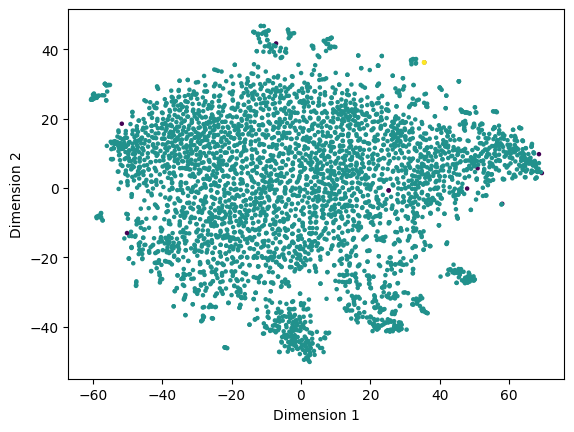

In [24]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s = 5, c = labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is t-SNE projection of the normalized gene data on a 2-D projection with labels (2 groups (cyan and yellow) and an outlier set (purple)) generated by DBSCAN. We can see that the clusters are not distinct over the projection - nearly the entire mass has one label and a tiny "island" of data is designated as the other cluster.

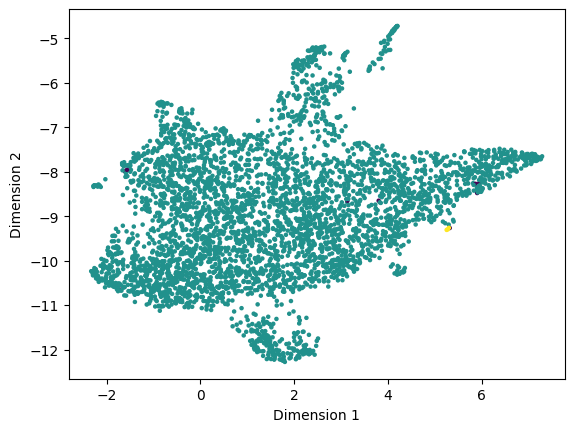

In [25]:
plt.scatter(u[:, 0], u[:, 1], s = 5, c = labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is UMAP projection of the normalized gene data on a 2-D projection with labels generated by DBSCAN. We can see that the clusters are not distinct over the projection - nearly the whole mass is labeled as the same cluster and a random smattering of points over this mass are considered outliers.

# 6: Agglomerative clustering


## 6a: Run agglomerative clustering with standard distance choices: ward linkage and Euclidean distance

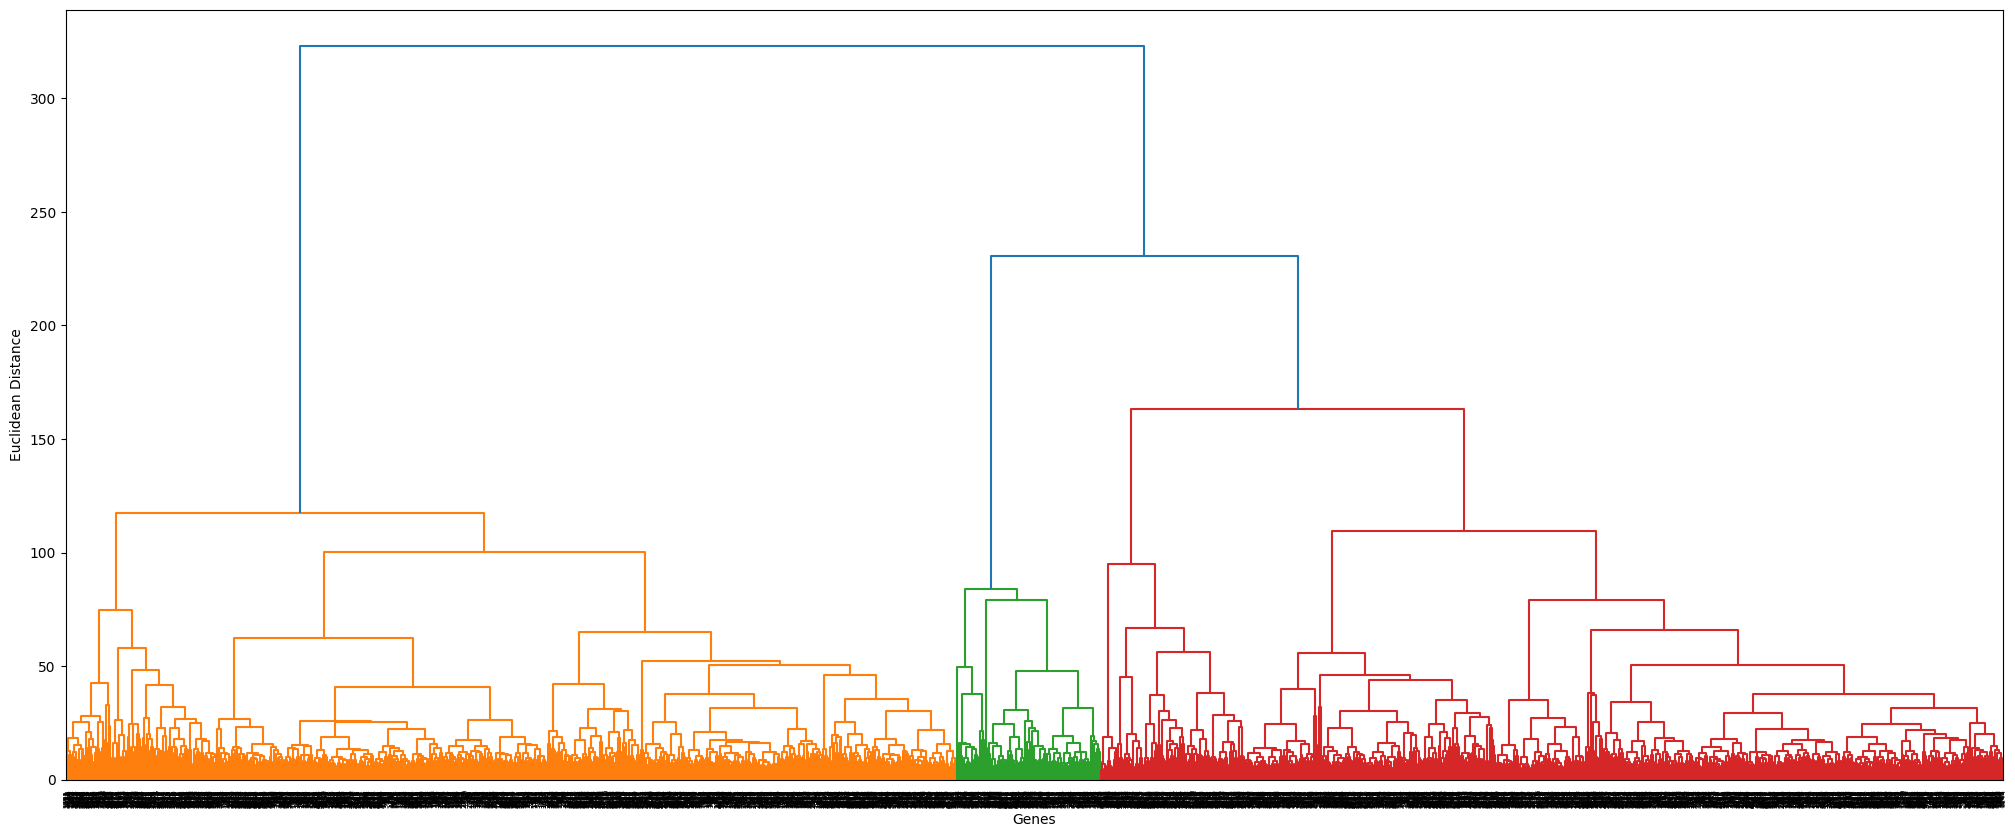

In [26]:
Z = linkage(scaledgenes, 'ward')
fig = plt.figure(figsize=(25, 10))
plt.xlabel("Genes")
plt.ylabel("Euclidean Distance")
dn = dendrogram(Z)

The above plot is a dendogram of the data using linkage = 'ward'. From this, we can see that the data can most easily be sorted into two groups and from that, one of the groups breaks off again. If we make a horizontal cut at Euclidean Distance = 200, we find that the # of optimal groups is 3. A cut at 300 would yeild 2 groups and a cut at 130 would recommend 4 clusters.

Repeat with a different linkage and comment on differences.



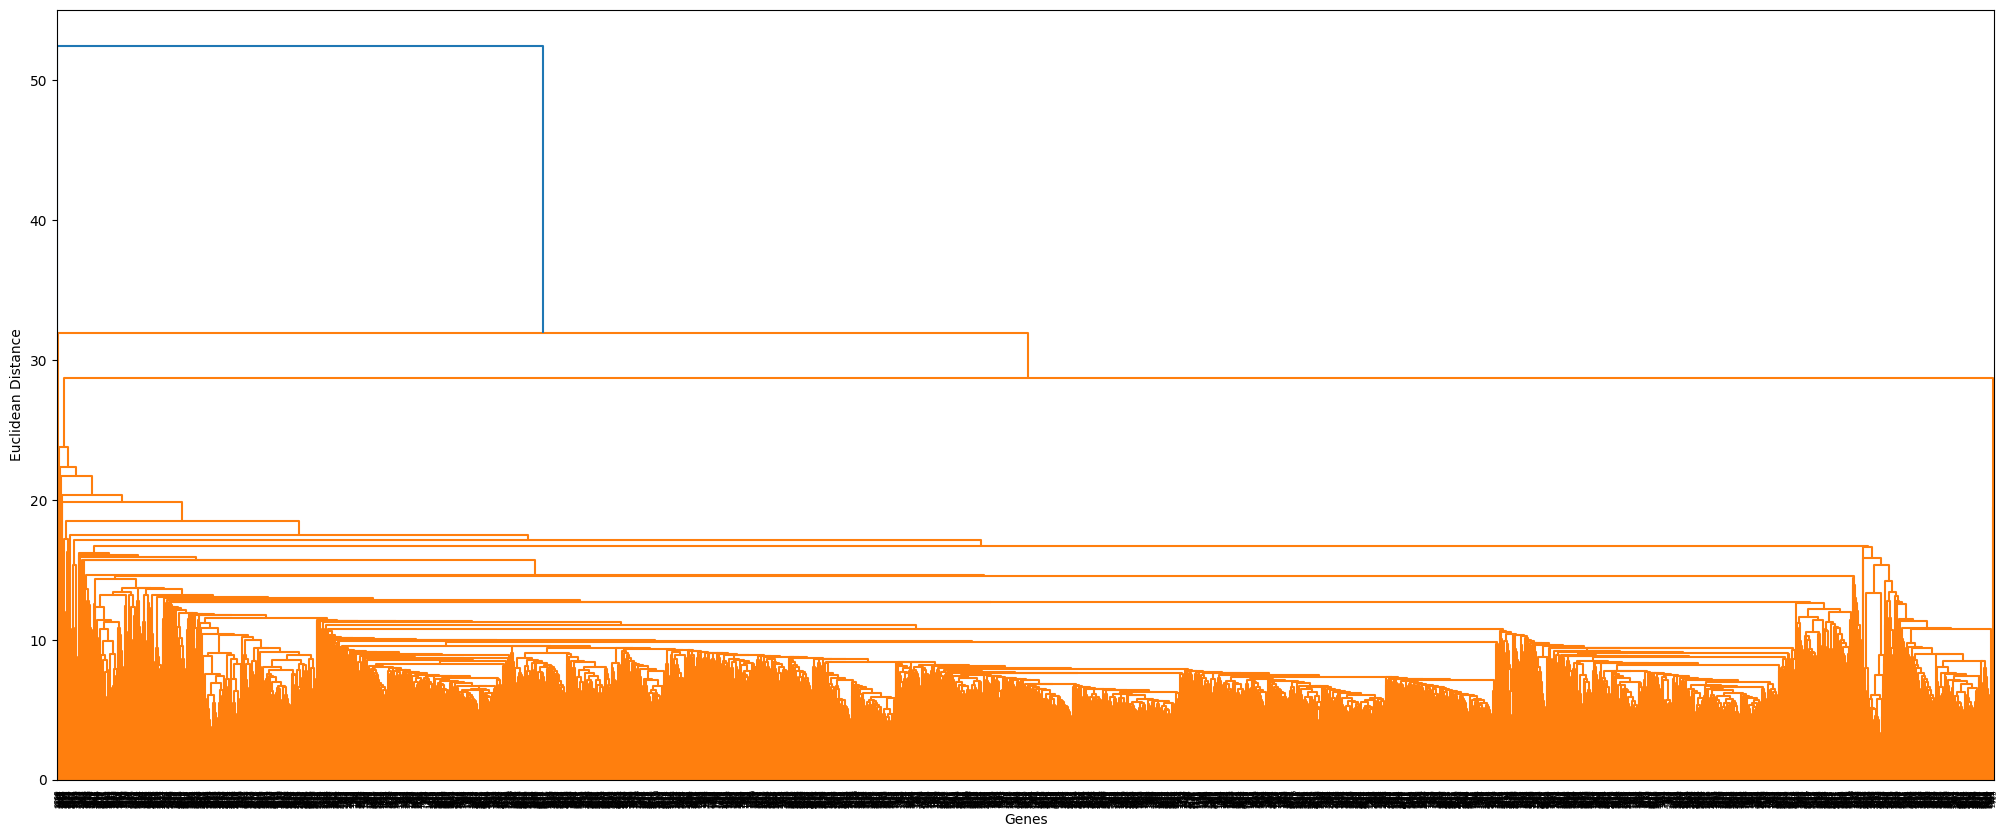

In [27]:
Z = linkage(scaledgenes, 'average')
fig = plt.figure(figsize=(25, 10))
plt.xlabel("Genes")
plt.ylabel("Euclidean Distance")
dn = dendrogram(Z)

The above plot is a dendogram of the data using linkage = 'average'. This is a bad way of visualizing the data and it is difficult to reach an conclusion from this besides: don't use linkage = 'average' for this dataset. When comparing this against the 'ward' linkage method, the main difference is that 'ward' yeilds a dendogram that is easily readible and conclusions can be reached from it while with linkage = 'average', you may reach the conlcusion that 4 groups would be better.

# 6b: Rerun agglomerative clustering to get the "ideal" number of clusters as decided by k-means.



In [28]:
clustering = AgglomerativeClustering(n_clusters = 3).fit(scaledgenes)
labels = clustering.labels_

## 6c: plot the 2D TSNE projection colorcoded as before

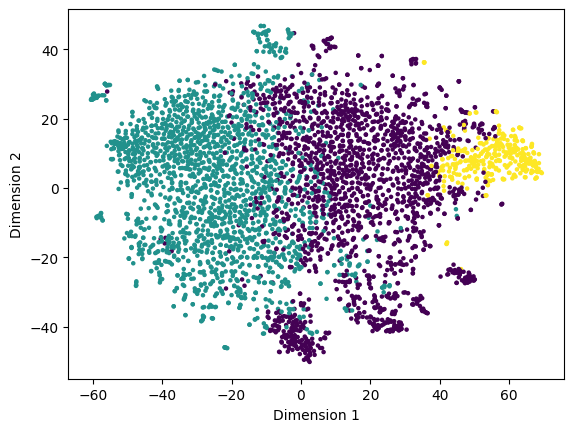

In [29]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s = 5, c = labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is t-SNE projection of the normalized gene data on a 2-D projection with labels generated by agglomerative clustering (three clusters). We can see that the clusters are not very distinct over the projection and that spacially, the clumps don't really make sense. There appears to be a left, middle, and right clump but islands like around (0,-40) and (45,-25) aren't seen by the clustering method.

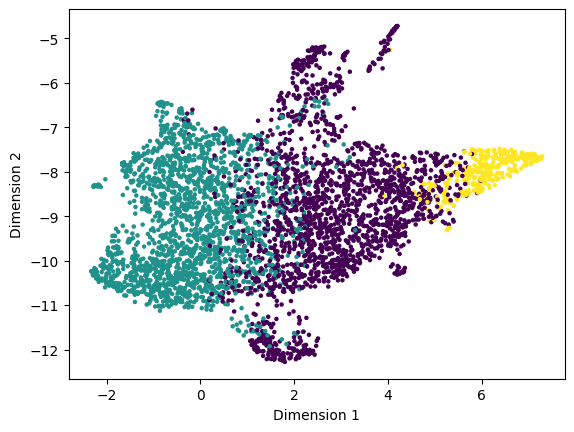

In [30]:
plt.scatter(u[:, 0], u[:, 1], s = 5, c = labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

The above plot is UMAP projection of the normalized gene data on a 2-D projection with labels generated by agglomerative clustering (three clusters). We can see that the clusters are not very distinct over the projection and that spacially, the clumps don't really make sense - there are a left, middle, and right clump but this method does not recognize the clump around (4,10).

# 7: Comment, in the spirit of https://www.ncbi.nlm.nih.gov/pmc/articles/PMC187526, which was the most "useful" method for clustering

Based on the above work, I find that the most "useful" method for clustering is either k-means w/ a small cluster number (what the paper says) or AgglomerativeClustering w/ cluster numbering chosen by analysis of a hierarchical dendogram. By eye, these seem to fit the t-SNE and UMAP projections the "best" but in truth, none of the clustering methods seem to be especially good - some of them just fit the projections better or worse. Different clustering methods may be "better" but look best in these projections. Similarly, different projections may support different clustering methods better for this data.